In [6]:
import pandas as pd
df = pd.read_csv("inference_data_indices.csv")
df['eventDate'] = pd.to_datetime(df['eventDate'], format='%Y-%m-%d', errors='coerce')

In [7]:
badgers = pd.read_csv("Meles meles.csv", delimiter='\t')
badgers = badgers[badgers["occurrenceStatus"] == "PRESENT"]
badgers = badgers[badgers['year']>=2022]
badgers['eventDate'] = pd.to_datetime(badgers['eventDate'], format='%Y-%m-%d', errors='coerce')
badgers = badgers[['species', 'decimalLatitude', 'decimalLongitude', 'eventDate']]
badgers = badgers.dropna().reset_index(drop=True)

ground_beetles = pd.read_csv("ground_beetles.csv", delimiter='\t')
ground_beetles = ground_beetles[ground_beetles["occurrenceStatus"] == "PRESENT"]
ground_beetles = ground_beetles[ground_beetles['year']>=2022]
ground_beetles['eventDate'] = pd.to_datetime(ground_beetles['eventDate'], format='%Y-%m-%d', errors='coerce')
ground_beetles = ground_beetles[['species', 'decimalLatitude', 'decimalLongitude', 'eventDate']]
ground_beetles = ground_beetles.dropna().reset_index(drop=True)

/var/folders/0n/sggn66691kd6g5mtyzpq2hv80000gn/T/ipykernel_80504/1507747312.py:1: DtypeWarning: Columns (10,16,39,41,45,46,48) have mixed types. Specify dtype option on import or set low_memory=False.
  badgers = pd.read_csv("Meles meles.csv", delimiter='\t')
/var/folders/0n/sggn66691kd6g5mtyzpq2hv80000gn/T/ipykernel_80504/1507747312.py:8: DtypeWarning: Columns (2,10,36,38,39,41,45,48) have mixed types. Specify dtype option on import or set low_memory=False.
  ground_beetles = pd.read_csv("ground_beetles.csv", delimiter='\t')


In [8]:
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree
from tqdm import tqdm

# Convert lat/lon to radians for BallTree
hedgehog_coords = np.deg2rad(df[['decimalLatitude', 'decimalLongitude']].values)
badger_coords = np.deg2rad(badgers[['decimalLatitude', 'decimalLongitude']].values)
ground_beetles_coords = np.deg2rad(ground_beetles[['decimalLatitude', 'decimalLongitude']].values)

# Build BallTrees
tree_badger = BallTree(badger_coords, metric='haversine')
tree_ground_beetles = BallTree(ground_beetles_coords, metric='haversine')

# 1 km radius in radians
radius = 1 / 6371.0

# Initialize presence columns
df['badger_presence'] = 0
df['ground_beetles_presence'] = 0

# Iterate through each hedgehog point with tqdm for progress tracking
for i in tqdm(range(len(df))):
    point = hedgehog_coords[i].reshape(1, -1)
    event_month = df.loc[i, 'eventDate'].month
    event_year = df.loc[i, 'eventDate'].year

    # BADGERS
    idxs = tree_badger.query_radius(point, r=radius)[0]
    for j in idxs:
        badger_date = badgers.loc[j, 'eventDate']
        if badger_date.month == event_month and badger_date.year == event_year:
            df.at[i, 'badger_presence'] = 1
            break  # Found at least one match, no need to check further

    # GROUND BEETLES
    idxs = tree_ground_beetles.query_radius(point, r=radius)[0]
    for j in idxs:
        beetle_date = ground_beetles.loc[j, 'eventDate']
        if beetle_date.month == event_month and beetle_date.year == event_year:
            df.at[i, 'ground_beetles_presence'] = 1
            break

100%|██████████| 244359/244359 [01:12<00:00, 3374.15it/s]


In [14]:
reference_data_near_road = pd.read_csv("temp.csv")
reference_data_near_road.head(10)

,decimalLongitude,decimalLatitude,eventDate,BSI,LST,MNDWI,NDBI,NDSI,NDVI,NDWI,SAVI,UI,ceratopogonidae_presence,chironomidae_presence,cats_presence,wind_turbines_presence,geometry,tile_x,tile_y,distance_to_road
0,-6.347425,49.893656,2025-06-01,-0.486515,289.980000,-0.283105,-0.237348,-0.283105,0.553412,-0.483623,0.829881,0.237348,0,0,0,0,POINT (-6.347425272382747 49.89365614995138),-405,5543,NaN
1,-6.333543,49.894177,2025-06-01,-0.533775,NaN,-0.313951,-0.229969,-0.313951,0.601115,-0.508422,0.901449,0.229969,0,0,0,0,POINT (-6.333542862518806 49.89417680762447),-404,5543,NaN
2,-6.321265,49.912633,2025-06-01,-0.444581,280.300000,-0.233918,-0.242840,-0.233918,0.516397,-0.431643,0.774486,0.242840,0,0,0,0,POINT (-6.321265107494903 49.9126325088973),-403,5545,NaN
3,-6.307377,49.913150,2025-06-01,-0.621371,289.999250,-0.391363,-0.281401,-0.391363,0.663213,-0.594777,0.994679,0.281401,0,0,0,0,POINT (-6.307376770926201 49.91315017696439),-402,5545,NaN
4,-6.293488,49.913666,2025-06-01,-0.719280,290.706667,-0.463755,-0.323644,-0.463755,0.756636,-0.684624,1.134827,0.323644,0,0,0,0,POINT (-6.293488032036451 49.91366618566916),-401,5545,NaN
5,-6.308177,49.922119,2025-06-01,-0.622208,289.918699,-0.331461,-0.355175,-0.331461,0.686171,-0.576160,1.029145,0.355175,0,0,0,0,POINT (-6.308177344226531 49.922118656074225),-402,5546,141.232549
6,-6.294286,49.922635,2025-06-01,-0.735673,289.861742,-0.472838,-0.320712,-0.472838,0.762024,-0.689002,1.142915,0.320712,0,0,0,0,POINT (-6.2942860435167125 49.92263482769373),-401,5546,588.979447
7,-6.280394,49.923149,2025-06-01,-0.203505,290.205625,-0.039216,-0.173743,-0.039216,0.326338,-0.194867,0.489282,0.173743,0,0,0,0,POINT (-6.280394341500885 49.92314933931474),-401,5547,588.719444
8,-6.350657,49.929528,2025-06-01,-0.063229,NaN,0.259624,-0.291776,0.259624,0.281165,-0.037273,0.421487,0.291776,0,0,0,0,POINT (-6.350657489343718 49.92952814605247),-405,5547,743.685394
9,-6.308978,49.931087,2025-06-01,-0.443792,289.147677,-0.187861,-0.298427,-0.187861,0.544639,-0.395426,0.816871,0.298427,0,0,0,0,POINT (-6.308978320110449 49.93108711178991),-402,5547,40.641827


In [10]:
df.head()

,decimalLongitude,decimalLatitude,eventDate,BSI,LST,MNDWI,NDBI,NDSI,NDVI,NDWI,SAVI,UI,badger_presence,ground_beetles_presence
0,-6.347425,49.893656,2025-06-01,-0.486515,289.980000,-0.283105,-0.237348,-0.283105,0.553412,-0.483623,0.829881,0.237348,0,0
1,-6.333543,49.894177,2025-06-01,-0.533775,NaN,-0.313951,-0.229969,-0.313951,0.601115,-0.508422,0.901449,0.229969,0,0
2,-6.321265,49.912633,2025-06-01,-0.444581,280.300000,-0.233918,-0.242840,-0.233918,0.516397,-0.431643,0.774486,0.242840,0,0
3,-6.307377,49.913150,2025-06-01,-0.621371,289.999250,-0.391363,-0.281401,-0.391363,0.663213,-0.594777,0.994679,0.281401,0,0
4,-6.293488,49.913666,2025-06-01,-0.719280,290.706667,-0.463755,-0.323644,-0.463755,0.756636,-0.684624,1.134827,0.323644,0,0


In [12]:
# copy values from near_road column in reference_data_near_road to near_road column in df where the decimalLatitude and decimalLongitude match
df['distance_to_road'] = 0
for i in tqdm(range(len(df))):
    lat = df.loc[i, 'decimalLatitude']
    lon = df.loc[i, 'decimalLongitude']
    match = reference_data_near_road[(reference_data_near_road['decimalLatitude'] == lat) & 
                                     (reference_data_near_road['decimalLongitude'] == lon)]
    if not match.empty:
        df.at[i, 'distance_to_road'] = match['distance_to_road'].values[0]

100%|██████████| 244359/244359 [03:48<00:00, 1067.08it/s]


In [27]:
df['near_road'] = np.where(df['distance_to_road'] <= 500, 1, 0)        
df=df.drop(['distance_to_road'], axis=1)
gdf = df

In [28]:
from pyproj import Transformer
from rasterio.windows import Window
import rasterio

land_cover_map = {
    1: "Deciduous woodland",
    2: "Coniferous woodland",
    3: "Arable",
    4: "Improved grassland",
    5: "Neutral grassland",
    6: "Calcareous grassland",
    7: "Acid grassland",
    8: "Fen",
    9: "Heather",
    10: "Heather grassland",
    11: "Bog",
    12: "Inland rock",
    13: "Saltwater",
    14: "Freshwater",
    15: "Supralittoral rock",
    16: "Supralittoral sediment",
    17: "Littoral rock",
    18: "Littoral sediment",
    19: "Saltmarsh",
    20: "Urban",
    21: "Suburban"
}

# Batch coordinate transformation
transformer_ni = Transformer.from_crs("EPSG:4326", "EPSG:29903", always_xy=True)
transformer_gb = Transformer.from_crs("EPSG:4326", "EPSG:27700", always_xy=True)

coords = list(zip(gdf['decimalLongitude'], gdf['decimalLatitude']))
gdf['easting_ni'], gdf['northing_ni'] = zip(*transformer_ni.itransform(coords))
gdf['easting_gb'], gdf['northing_gb'] = zip(*transformer_gb.itransform(coords))

# Raster processing optimization
gb_raster = 'gblcm2023_10m.tif'
n_ireland_raster = 'nilcm2023_10m.tif'


def get_land_cover_class(row):
    try:
        # Try GB raster first
        with rasterio.open(gb_raster) as src:
            row_idx, col_idx = src.index(row['easting_gb'], row['northing_gb'])
            # Read a small window around the point for better performance
            window = Window(col_idx, row_idx, 1, 1)
            land_cover_class = src.read(1, window=window)[0, 0]

            if land_cover_class == 0:  # Check NI raster if GB is 0
                with rasterio.open(n_ireland_raster) as src_ni:
                    row_idx, col_idx = src_ni.index(row['easting_ni'], row['northing_ni'])
                    window = Window(col_idx, row_idx, 1, 1)
                    land_cover_class = src_ni.read(1, window=window)[0, 0]

        return land_cover_map.get(land_cover_class, "Unknown")
    except Exception as e:
        print(f"Error processing row: {e}")
        return "Unknown"


tqdm.pandas()
gdf['Land_cover'] = gdf.progress_apply(get_land_cover_class, axis=1)


  0%|          | 1067/244359 [00:31<4:11:01, 16.15it/s]

Error processing row: index 0 is out of bounds for axis 0 with size 0


 19%|█▉        | 46150/244359 [09:42<12:50, 257.19it/s]  

Error processing row: index 0 is out of bounds for axis 0 with size 0


 32%|███▏      | 79238/244359 [11:54<11:03, 248.87it/s]

Error processing row: index 0 is out of bounds for axis 0 with size 0


 61%|██████    | 148831/244359 [17:48<16:24, 97.07it/s] 

Error processing row: index 0 is out of bounds for axis 1 with size 0


 94%|█████████▎| 228902/244359 [26:15<00:55, 279.14it/s]

Error processing row: index 0 is out of bounds for axis 0 with size 0


 95%|█████████▌| 232288/244359 [26:41<01:01, 196.47it/s]

Error processing row: index 0 is out of bounds for axis 0 with size 0


 95%|█████████▌| 232571/244359 [26:42<00:42, 276.02it/s]

Error processing row: index 0 is out of bounds for axis 0 with size 0


 98%|█████████▊| 239054/244359 [27:19<00:38, 137.46it/s]

Error processing row: index 0 is out of bounds for axis 0 with size 0


 99%|█████████▉| 242715/244359 [27:44<00:16, 100.20it/s]

Error processing row: index 0 is out of bounds for axis 0 with size 0


 99%|█████████▉| 242746/244359 [27:44<00:14, 109.84it/s]

Error processing row: index 0 is out of bounds for axis 0 with size 0


100%|██████████| 244359/244359 [27:56<00:00, 145.78it/s]


In [31]:
gdf = gdf.dropna()
gdf=gdf.drop(['easting_ni', 'northing_ni', 'easting_gb', 'northing_gb'],axis=1)
# Remove where Land_cover is Unknown
gdf = gdf[gdf['Land_cover'] != "Unknown"].reset_index(drop=True)
gdf.to_csv("hedgehog_inference_data_preprocessed.csv", index=False)

In [33]:
gdf = gdf.dropna()
gdf = gdf.drop_duplicates()
hedgehog_bool_columns = ['badger_presence','ground_beetles_presence','near_road']
gdf[hedgehog_bool_columns] = gdf[hedgehog_bool_columns].astype(bool)
gdf = pd.get_dummies(gdf, columns=['Land_cover'])
gdf.to_csv("hedgehog_inference_data_preprocessed.csv")

In [39]:
gdf = pd.read_csv("hedgehog_inference_data_preprocessed.csv")
gdf = gdf.astype({col: 'int' for col in gdf.select_dtypes(include='bool').columns})

#read scaler
import joblib
scaler = joblib.load("hedgehog_scaler.pkl")
# Scale the data
env_vars = ['BSI', 'LST', 'MNDWI', 'NDBI', 'NDSI', 'NDVI', 'NDWI', 'SAVI', 'UI']
gdf[env_vars] = scaler.transform(gdf[env_vars])
# drop Unnamed: 0
gdf = df.drop(columns=['Unnamed: 0'])


In [40]:
gdf.to_csv("hedgehog_inference_data_preprocessed_final.csv", index=False)

In [6]:
import pandas as pd
df = pd.read_csv("hedgehog_inference_data_preprocessed_final.csv")


In [7]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

class DeepMaxEntModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=250, num_hidden_layers=2):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_dim, hidden_dim) for _ in range(num_hidden_layers)]
        )
        self.output_layer = nn.Linear(hidden_dim, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.activation(x)
        for layer in self.hidden_layers:
            residual = x
            out = layer(x)
            out = self.activation(out)
            x = out + residual
        return self.output_layer(x)

    def predict_proba(self, x):
        return torch.sigmoid(self.forward(x))

# ============================
# Custom deepmaxent_loss
# ============================
def deepmaxent_loss(logits, targets):
    probs = torch.sigmoid(logits)
    eps = 1e-8
    loss = - (targets * torch.log(probs + eps) +
              (1 - targets) * torch.log(1 - probs + eps))
    return loss.mean()

In [8]:
import numpy as np

models_list = ["hedgehog_deepmaxent_loss_boyce_best_model.pth", "hedgehog_BCEWithLogitsLoss_boyce_best_model.pth"]
input_dim = df.shape[1] - 3  # Exclude 'decimalLatitude', 'decimalLongitude', 'eventDate'

X_inference = df.drop(columns=['decimalLatitude', 'decimalLongitude', 'eventDate']).values
X_inference_tensor = torch.tensor(X_inference, dtype=torch.float32)

all_probs = []
for model_path in models_list:
        model = DeepMaxEntModel(input_dim=input_dim)
        model.load_state_dict(torch.load(model_path))
        model.eval()
        with torch.no_grad():
            probs = model.predict_proba(X_inference_tensor).cpu().numpy().ravel()
            all_probs.append(probs)
    
# Average probabilities
ensemble_probs = np.mean(all_probs, axis=0)

# add probabilities to df
df['probability'] = ensemble_probs # Assuming the second column is the positive class
df.to_csv("hedgehog_results.csv", index=False)
df

,decimalLongitude,decimalLatitude,eventDate,BSI,LST,MNDWI,NDBI,NDSI,NDVI,NDWI,...,Land_cover_Littoral rock,Land_cover_Littoral sediment,Land_cover_Neutral grassland,Land_cover_Saltmarsh,Land_cover_Saltwater,Land_cover_Suburban,Land_cover_Supralittoral rock,Land_cover_Supralittoral sediment,Land_cover_Urban,probability
0,-6.347425,49.893656,2025-06-01,0.067140,-0.132752,0.346347,-0.411514,0.346347,0.144295,0.094182,...,0,0,0,0,0,1,0,0,0,0.722862
1,-6.321265,49.912633,2025-06-01,0.255769,-1.327859,0.581444,-0.458528,0.581444,-0.041104,0.374718,...,0,0,0,0,0,0,0,0,0,0.078849
2,-6.307377,49.913150,2025-06-01,-0.539469,-0.130375,-0.171093,-0.788597,-0.171093,0.694261,-0.505716,...,0,0,0,0,0,1,0,0,0,0.642020
3,-6.293488,49.913666,2025-06-01,-0.979886,-0.043036,-0.517101,-1.150183,-0.517101,1.162195,-0.990623,...,0,0,0,0,0,0,0,0,0,0.375879
4,-6.308177,49.922119,2025-06-01,-0.543234,-0.140320,0.115221,-1.420081,0.115221,0.809249,-0.405242,...,0,0,0,0,0,0,0,0,1,0.950096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243512,-0.808766,60.824609,2025-06-01,-0.896223,-0.889683,-1.112711,0.289226,-1.112711,0.746908,-0.973289,...,0,0,0,0,0,0,0,0,0,0.522576
243513,-0.790383,60.824445,2025-06-01,0.855900,-0.658977,0.954066,0.777556,0.954066,-0.559611,1.441090,...,0,0,0,0,0,0,0,0,0,0.033173
243514,-0.881988,60.834217,2025-06-01,-0.740995,-0.804300,-0.830183,0.057020,-0.830183,0.680422,-0.799522,...,0,0,0,0,0,0,0,0,0,0.529814
243515,-0.845210,60.833906,2025-06-01,0.373337,-0.923579,0.109861,1.188584,0.109861,-0.537257,0.775508,...,0,0,0,0,0,0,0,0,0,0.396344


/var/folders/0n/sggn66691kd6g5mtyzpq2hv80000gn/T/ipykernel_71906/683392986.py:15: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  uk_union = uk_countries.unary_union


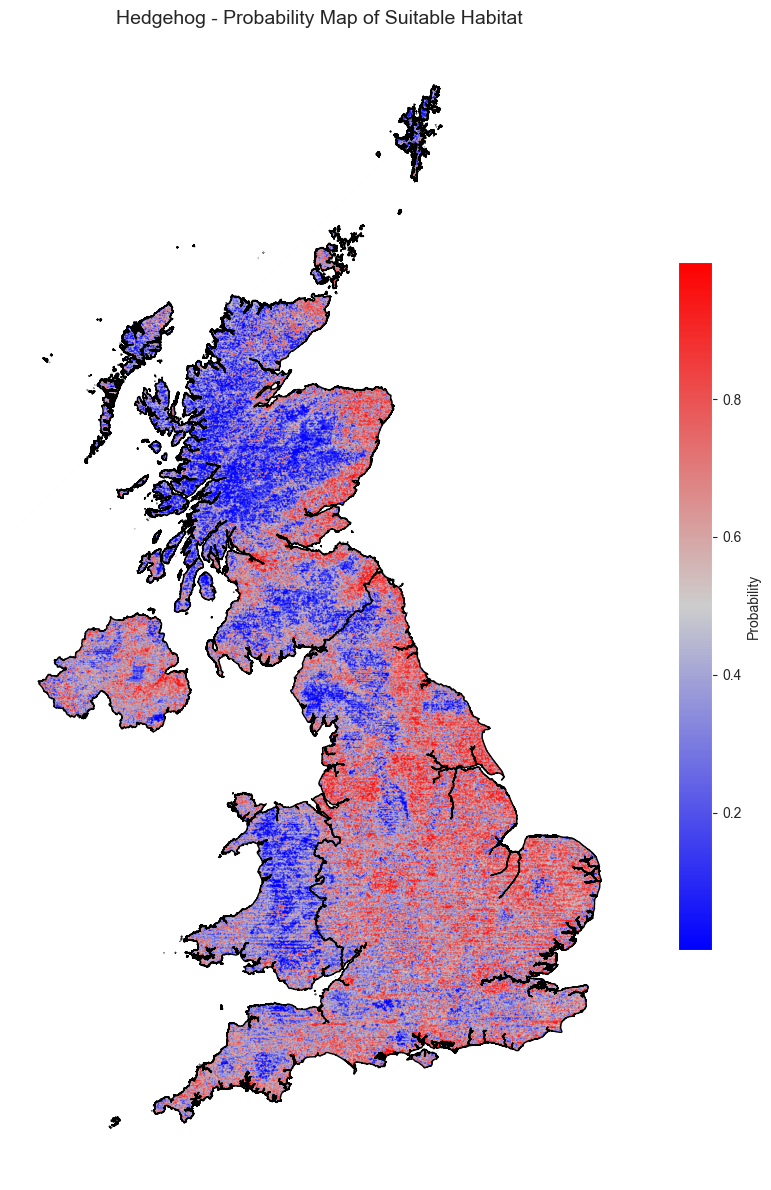

In [9]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.interpolate import griddata
from shapely.geometry import Point
from shapely.prepared import prep

# Load UK shapefile and prepare land geometry
uk_countries = gpd.read_file('data/CTRY_DEC_2024_UK_BFC.shp')
uk_countries = uk_countries[
    uk_countries['CTRY24NM'].isin(['England', 'Scotland', 'Wales', 'Northern Ireland'])
].to_crs('EPSG:27700')
uk_union = uk_countries.unary_union
uk_polygon = prep(uk_union)  # prepared geometry for fast masking

# Load and project point data
data = pd.read_csv("hedgehog_results.csv")
points_gdf = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data.decimalLongitude, data.decimalLatitude),
    crs='EPSG:4326'
).to_crs('EPSG:27700')

# Interpolation setup
x = points_gdf.geometry.x.values
y = points_gdf.geometry.y.values
z = points_gdf['probability'].values

# Create fine grid (500m resolution)
grid_res = 500
xi = np.arange(x.min(), x.max(), grid_res)
yi = np.arange(y.min(), y.max(), grid_res)
xi, yi = np.meshgrid(xi, yi)

# Interpolate with linear method
zi = griddata((x, y), z, (xi, yi), method='linear')

# Mask grid: keep only points inside the UK polygon
grid_points = [Point(x, y) for x, y in zip(xi.flatten(), yi.flatten())]
mask = np.array([uk_polygon.contains(pt) for pt in grid_points])
zi_masked = np.ma.masked_where(~mask.reshape(xi.shape), zi)

# Define colormap
cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom",
    ["blue",
     # "#7072EE", 
     # "#00CDFF", 
     "#CDCDCD", 
     # "#FF00FE", 
     # "#FC79f6", 
     "red"]
)
norm = mcolors.Normalize(vmin=np.nanmin(zi_masked), vmax=np.nanmax(zi_masked))

# Plot
fig, ax = plt.subplots(figsize=(10, 12))
img = ax.imshow(
    zi_masked,
    origin='lower',
    extent=(xi.min(), xi.max(), yi.min(), yi.max()),
    cmap=cmap,
    norm=norm
)

# Overlay UK boundaries
uk_countries.boundary.plot(ax=ax, color='black', linewidth=1)

# Colorbar
cbar = plt.colorbar(img, ax=ax, shrink=0.6, label='Probability')
ax.set_title('Hedgehog - Probability Map of Suitable Habitat', fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [10]:
#save the image
fig.savefig("hedgehog_probability_map.png", dpi=300, bbox_inches='tight')